# Convolutional Neural Networks

<img src="digit.jpg" alt="digit image" width="230"/>

Let's learn about convolutional neural networks (CNN). Rather than using linear layers, we mainly use CNN on images. Compared to using linear layers, we can get more accuracy faster because CNN has fewer parameters to train and can capture patterns easily.


First, we setup environments. For data, we will use MNIST digits.

In [19]:
from torch import tensor, nn
import pickle, gzip, torch, matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [13]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [20]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Conv1d

Let's go over how Pytroch's convolutional neural networks work. We will start with a simple example, which is `Conv1d`. Let's say we have a vector with shape `(1, 2)`. We can think of this vector as a sentence with two words, like "I sit," and converted numbers into numbers so that computers can understand.

In [41]:
torch.manual_seed(1)
sent1 = torch.randn((1, 2))
sent1

tensor([[0.66, 0.27]])

Here is a `Conv1d` layer with 1 input, 1 output, 2 kernel_size. When we look at the weight of this layer, it is the kernels. Its shape corresponds to `(output, input, kernel_size)`. In this simple case, we have one kernel with size 2 kernel. The shape of bias depends on the output of the layer.

In [36]:
layer1 = nn.Conv1d(1, 1, kernel_size=2)
layer1

Conv1d(1, 1, kernel_size=(2,), stride=(1,))

In [37]:
layer1.weight, layer1.weight.shape

(Parameter containing:
 tensor([[[-0.28, -0.05]]], requires_grad=True),
 torch.Size([1, 1, 2]))

In [38]:
layer1.bias

Parameter containing:
tensor([-0.06], requires_grad=True)

When we apply this layer to our sentence, we get -0.26, which is the same as calculating a dot product of weight and the sentence added by bias.

In [40]:
layer1(sent1)

tensor([[-0.26]], grad_fn=<SqueezeBackward1>)

In [43]:
(layer1.weight * sent1).sum() + layer1.bias

tensor([-0.26], grad_fn=<AddBackward0>)

When we set the output to 2, that means there are two kernels: one for each output. We generally refer to output as a channel. So, when we increase the output, we say we grow the channel. We will talk about why it would be helpful later.

In [44]:
layer2 = nn.Conv1d(1, 2, kernel_size=2)
layer2

Conv1d(1, 2, kernel_size=(2,), stride=(1,))

In [45]:
layer2.weight, layer2.weight.shape

(Parameter containing:
 tensor([[[-0.67,  0.42]],
 
         [[-0.15,  0.36]]], requires_grad=True),
 torch.Size([2, 1, 2]))

In [46]:
layer2.bias

Parameter containing:
tensor([ 0.10, -0.09], requires_grad=True)

In [47]:
layer2(sent1)

tensor([[-0.23],
        [-0.09]], grad_fn=<SqueezeBackward1>)

In [50]:
(layer2.weight[0] * sent1).sum() + layer2.bias[0]

tensor(-0.23, grad_fn=<AddBackward0>)

In [51]:
(layer2.weight[1] * sent1).sum() + layer2.bias[1]

tensor(-0.09, grad_fn=<AddBackward0>)

That was simple. What if the sentence is longer than 2 words? Let's say we have 4 words this time. When we apply `layer1` to it, we get 3 numbers.

In [54]:
sent2 = torch.randn((1, 4))
sent2

tensor([[ 0.86,  0.71, -0.34, -1.27]])

In [61]:
layer1(sent2)

tensor([[-0.34, -0.24,  0.10]], grad_fn=<SqueezeBackward1>)

We can imagine our kernel as a sliding window moving from left to right. That's what `stride` is. By default, it is 1 and moves 1 step by step. This is how it is calculated:

In [64]:
for words in [sent2[0][i:i+2] for i in range(len(sent2[0]) - 1)]:
    print((layer1.weight * words).sum() + layer1.bias)

tensor([-0.34], grad_fn=<AddBackward0>)
tensor([-0.24], grad_fn=<AddBackward0>)
tensor([0.10], grad_fn=<AddBackward0>)


### Stride and Padding

So that's basically how convolution works. By setting different values to stride, we can change how many times the kernel moves each step. By setting stride to 2, we skip some computations.

In [67]:
layer3 = nn.Conv1d(1, 1, kernel_size=2, stride=2)
layer3

Conv1d(1, 1, kernel_size=(2,), stride=(2,))

In [68]:
layer3(sent2)

tensor([[0.25, 0.46]], grad_fn=<SqueezeBackward1>)

Because the kernel moved twice each step, it is now instead of 3 values, we have 2 values as an output. This way, we can reduce the number of input pixels, which means we can store information more compactly, like zipping a file. However, this might lose data if we shrink too much at once. Therefore, we increase the input channel by using stride to balance it.

For instance, if we use stride 2, we half height and width, which results in 4 times less pixels. By adding a channel, we increase the output by 2 times. Therefore, we only divide the pixel by 2 for each layer, which is reasonable for the neural net to learn patterns.

What is padding, then? It is a way to put zeroes in the corner. If padding is 2, we put 2 zeroes on the left and right of our sentence before applying kernels. Therefore, first and last values are equal to just biases in this example.

In [71]:
sent2

tensor([[ 0.86,  0.71, -0.34, -1.27]])

In [69]:
layer4 = nn.Conv1d(1, 1, kernel_size=2, stride=2, padding=2)
layer4

Conv1d(1, 1, kernel_size=(2,), stride=(2,), padding=(2,))

In [70]:
layer4(sent2)

tensor([[0.44, 0.28, 1.19, 0.44]], grad_fn=<SqueezeBackward1>)

In [80]:
layer4.bias

Parameter containing:
tensor([0.44], requires_grad=True)

## Conv2d

We've been using `conv1d`, but `conv2d` works the same way, except we have 2-dimensional kernels, which also move down.

In [86]:
layer5 = nn.Conv2d(1, 1, kernel_size=2, stride=1, padding=0)
layer5

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))

In [92]:
layer5.weight.shape, layer5.bias.shape

(torch.Size([1, 1, 2, 2]), torch.Size([1]))

Shape of weight: (Outp, Inp, *Kernel_size)

Shape of bias: Outp

Let's start with a simple example again. Here is a small image with 3 pixels high and 3 pixels wide.

In [93]:
im1 = torch.randn((1, 3, 3))
im1

tensor([[[ 0.20,  0.15, -0.25],
         [ 2.01,  0.86,  0.61],
         [-1.17,  1.11,  0.33]]])

In [94]:
im1.shape

torch.Size([1, 3, 3])

In [95]:
layer5(im1), layer5(im1).shape

(tensor([[[0.10, 0.21],
          [2.07, 0.65]]], grad_fn=<SqueezeBackward1>),
 torch.Size([1, 2, 2]))

So, now let's talk about different kernels. Why do we even use kernels? What do they do? So, let's say we have an image of digit 5 from MNIST.

In [140]:
def show_im(im, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    if all(hasattr(im, x) for x in ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im)

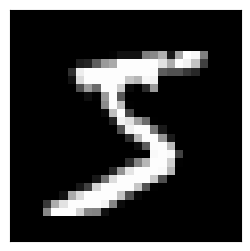

In [141]:
im2 = x_train[0].reshape((1, 28, 28))
show_im(im2, figsize=(3,3))

In [132]:
layer6 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
layer6, layer6.weight.shape

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)), torch.Size([1, 1, 3, 3]))

Here is a kernel that detects the top edge. We can apply this kernel to find the top edge of an image. Let's see what it looks like.

In [133]:
top_edge = torch.nn.Parameter(tensor([[1,1,1],[0,0,0],[-1,-1,-1]],
                                     dtype=torch.float32).reshape((1, 1, 3, 3)))
top_edge

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]]], requires_grad=True)

In [134]:
top_edge.shape

torch.Size([1, 1, 3, 3])

In [135]:
layer6.weight = top_edge
layer6.weight

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]]], requires_grad=True)

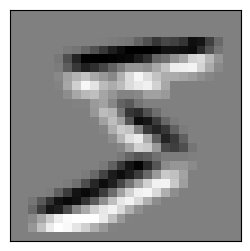

In [142]:
show_im(layer6(im2), figsize=(3,3));

We successfully detected top edge of the image! Let's try to get the right edge.

In [145]:
layer7 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
layer7

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [146]:
right_edge = torch.nn.Parameter(tensor([[-1,0,1],
       [-1,0,1],
       [-1,0,1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
right_edge

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

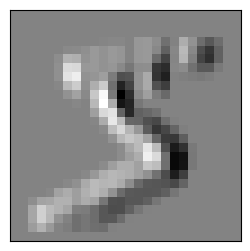

In [149]:
layer7.weight = right_edge
show_im(layer7(im2), figsize=(3,3));

That's cool. By using multiple kernels, we can combine those to detect more complicated shapes, such as waves and wheels.

## Conclusion

In this blog, we learned how convolutional neural networks by using Pytorch. It is used mainly for images. If you want to learn more, look at FastAI [lesson 8](https://course.fast.ai/Lessons/lesson8.html). It might be easier to watch the video to understand, and you can come back to play around with the code.

For a challenge, you can try to train MNIST using linear layers and convolutional neural networks and find out which is better.